In [1]:
from tensorflow.keras.layers import Input, Conv2D, Dropout, Flatten, Dense, MaxPool2D, Activation, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import Precision
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import cv2 as cv
import random
import os

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


1 Physical GPUs, 1 Logical GPUs


In [3]:
def read_image(path, images, labels, filenames):
    
    for root, dirs, files in os.walk(path):

        for name in dirs:
            
            direct = os.path.join(path, name)
            
            for filename in os.listdir(direct):
                
                img = cv.imread(os.path.join(path + "/" + name, filename))
                labels.append(name)
                img = cv.resize(img, Image_Size)
                images.append(img)
                filenames.append(name + '/' + filename)

In [4]:
def create_dataframe(filenames, labels):
    
    df = pd.DataFrame({
        
    'filename' : filenames,
    'category' : labels

    })
    
    return df

In [5]:
def draw_countplot(dataframe, y_axis, title):
    
    sns.countplot(data=dataframe, y = y_axis, width=0.3, palette = 'Set2')
    plt.title(title, weight='black')
    plt.show()

In [6]:
Image_Width=250   #600
Image_Height=250  #400
Image_Size=(Image_Width,Image_Height)
Image_Channels=3
batch_size = 32

In [7]:
train_filenames = []
train_images = []
train_labels = []
train_path = './DermMel/train_sep/'

read_image(path=train_path, images=train_images, labels=train_labels, filenames=train_filenames)

### Train Data

In [8]:
train_df = create_dataframe(filenames=train_filenames, labels=train_labels)
train_df

,filename,category
0,Melanoma/AUGmented_0_1000.jpeg,Melanoma
1,Melanoma/AUGmented_0_1007.jpeg,Melanoma
2,Melanoma/AUGmented_0_1009.jpeg,Melanoma
3,Melanoma/AUGmented_0_1022.jpeg,Melanoma
4,Melanoma/AUGmented_0_1029.jpeg,Melanoma
...,...,...
10677,NotMelanoma/ISIC_0034314.jpg,NotMelanoma
10678,NotMelanoma/ISIC_0034315.jpg,NotMelanoma
10679,NotMelanoma/ISIC_0034318.jpg,NotMelanoma
10680,NotMelanoma/ISIC_0034319.jpg,NotMelanoma


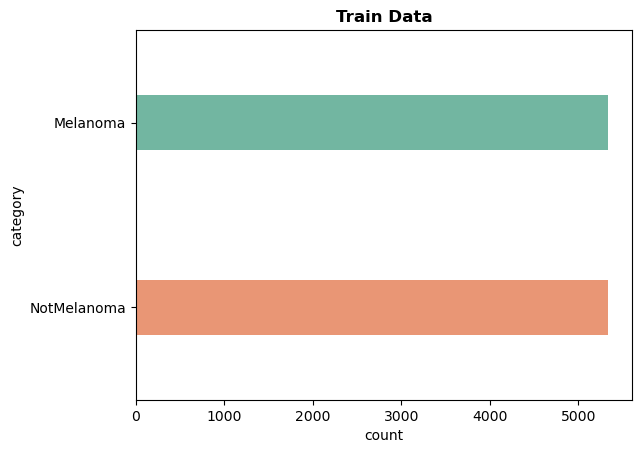

In [9]:
draw_countplot(dataframe=train_df, y_axis='category', title='Train Data')

In [10]:
test_filenames = []
test_images = []
test_labels = []
test_path = './DermMel/test/'

read_image(path=test_path, images=test_images, labels=test_labels, filenames=test_filenames)

### Test Data

In [11]:
test_df = create_dataframe(filenames=test_filenames, labels=test_labels)
test_df

,filename,category
0,Melanoma/AUGmented_0_1015.jpeg,Melanoma
1,Melanoma/AUGmented_0_1036.jpeg,Melanoma
2,Melanoma/AUGmented_0_1093.jpeg,Melanoma
3,Melanoma/AUGmented_0_1110.jpeg,Melanoma
4,Melanoma/AUGmented_0_1114.jpeg,Melanoma
...,...,...
3556,NotMelanoma/ISIC_0034257.jpg,NotMelanoma
3557,NotMelanoma/ISIC_0034260.jpg,NotMelanoma
3558,NotMelanoma/ISIC_0034278.jpg,NotMelanoma
3559,NotMelanoma/ISIC_0034309.jpg,NotMelanoma


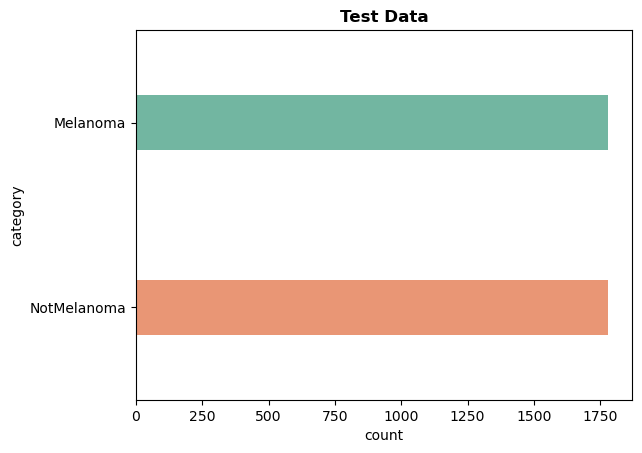

In [12]:
draw_countplot(dataframe=test_df, y_axis='category', title='Test Data')

In [13]:
#preprocessing
train_datag=ImageDataGenerator(rescale=1./ 255)#rescalling

train_dataset=train_datag.flow_from_dataframe(dataframe=train_df, #data_frame of data
                                              directory=train_path, #path
                                              x_col="filename",
                                              y_col="category",
                                              target_size=Image_Size, #resize image it doesnt mean converting into 2d we can give only height and breadth
                                              batch_size=32, #by default 32
                                              # validate_filenames= False
                                             )

Found 10682 validated image filenames belonging to 2 classes.


In [14]:
test_datag=ImageDataGenerator(rescale=1./255)
test_dataset=test_datag.flow_from_dataframe(dataframe=test_df,
                                            directory=test_path,
                                            x_col="filename",
                                            y_col="category",
                                            target_size=Image_Size,
                                            batch_size=32,
                                            validate_filenames=False
                                           )

Found 3561 non-validated image filenames belonging to 2 classes.


In [15]:
train_dataset.class_indices #gives the class of target values

{'Melanoma': 0, 'NotMelanoma': 1}

In [16]:
train_dataset[0][0].shape# 0 batch# 32 batches 128-h 128-w,3d image

(32, 250, 250, 3)

In [17]:
model=Sequential([
    Input(shape=(Image_Width, Image_Height, Image_Channels)),
    #con layer1
    Conv2D(filters=16 ,kernel_size=(3,3), strides=(1,1), padding="valid", activation="relu"),#no.of kernels,k.size,strides,padding=same keeps input ouput same size valid means no padding
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),
    Dropout(0.2),
    
    #conv layer-2
    Conv2D(filters=32, kernel_size=(3,3),activation="relu"),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),
    Dropout(0.2),
    
    
    #conv layer-3
    Conv2D(filters=32, kernel_size=(3,3),activation="relu"),
    BatchNormalization(),    
    MaxPool2D(pool_size=(2,2)),
    Dropout(0.2),
    
    #FLATTENNING
    Flatten(),
    
    #NN
    Dense(units=64,activation="relu"),
    Dense(units=32,activation="relu"),
    
    
    #output layer
    Dense(units=2,activation="softmax")
    
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 248, 248, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 248, 248, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 124, 124, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 124, 124, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 32)      4640      
                                                                 
 batch_normalization_1 (Batc  (None, 122, 122, 32)     1

In [18]:
model.compile(loss="CategoricalCrossentropy",optimizer="adam",metrics=["accuracy", Precision()])

In [19]:
history = model.fit(train_dataset, epochs=29, validation_data=test_dataset)

Epoch 1/29
334/334 [==============================] - 56s 157ms/step - loss: 0.4861 - accuracy: 0.8130 - precision: 0.8130 - val_loss: 0.5681 - val_accuracy: 0.7150 - val_precision: 0.7150
Epoch 2/29
334/334 [==============================] - 52s 154ms/step - loss: 0.2483 - accuracy: 0.8978 - precision: 0.8978 - val_loss: 2.4640 - val_accuracy: 0.5114 - val_precision: 0.5114
Epoch 3/29
334/334 [==============================] - 51s 153ms/step - loss: 0.2100 - accuracy: 0.9156 - precision: 0.9156 - val_loss: 3.9065 - val_accuracy: 0.5939 - val_precision: 0.5939
Epoch 4/29
334/334 [==============================] - 52s 155ms/step - loss: 0.1981 - accuracy: 0.9182 - precision: 0.9182 - val_loss: 0.4871 - val_accuracy: 0.8088 - val_precision: 0.8088
Epoch 5/29
334/334 [==============================] - 51s 153ms/step - loss: 0.1679 - accuracy: 0.9309 - precision: 0.9309 - val_loss: 2.7479 - val_accuracy: 0.6268 - val_precision: 0.6268
Epoch 6/29
334/334 [==============================] - 5

In [20]:
model.save("melanoma-classifier.h5")
print("Saved model to disk")

Saved model to disk


In [21]:
validation_filenames = []
validation_images = []
validation_labels = []
validation_path = './DermMel/valid/'

read_image(path=validation_path, images=validation_images, labels=validation_labels, filenames=validation_filenames)

### Validation Data

In [22]:
val_df = create_dataframe(filenames=validation_filenames, labels=validation_labels)
val_df

,filename,category
0,Melanoma/AUGmented_0_1006.jpeg,Melanoma
1,Melanoma/AUGmented_0_1058.jpeg,Melanoma
2,Melanoma/AUGmented_0_110.jpeg,Melanoma
3,Melanoma/AUGmented_0_1108.jpeg,Melanoma
4,Melanoma/AUGmented_0_1140.jpeg,Melanoma
...,...,...
3557,NotMelanoma/ISIC_0034292.jpg,NotMelanoma
3558,NotMelanoma/ISIC_0034297.jpg,NotMelanoma
3559,NotMelanoma/ISIC_0034305.jpg,NotMelanoma
3560,NotMelanoma/ISIC_0034308.jpg,NotMelanoma


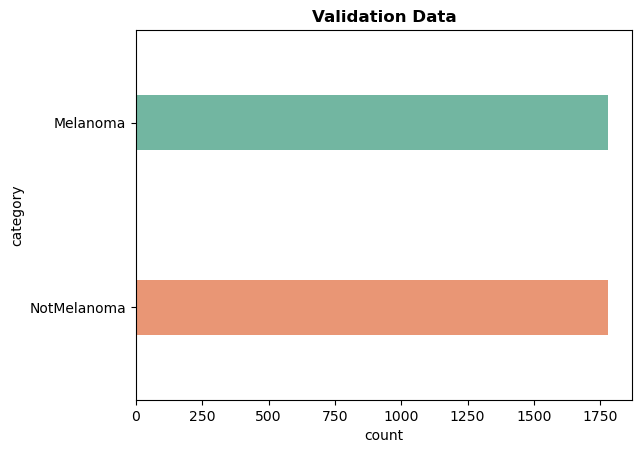

In [23]:
draw_countplot(dataframe=val_df, y_axis='category', title='Validation Data')

In [24]:
val_datag=ImageDataGenerator(rescale=1./255)
val_dataset=val_datag.flow_from_dataframe(dataframe=val_df,
                                            directory=validation_path,
                                            x_col="filename",
                                            y_col="category",
                                            target_size=Image_Size,
                                            batch_size=32,
                                            validate_filenames=False
                                           )

Found 3562 non-validated image filenames belonging to 2 classes.


In [25]:
test_pred=model.predict(test_dataset)

112/112 [==============================] - 14s 121ms/step


In [26]:
test_df["predict"]=np.argmax(test_pred,axis=1)

In [27]:
test_df["predict_c"]=test_df["predict"].map({0:"NotMelanoma",1:"Melanoma"})

In [28]:
test_df

,filename,category,predict,predict_c
0,Melanoma/AUGmented_0_1015.jpeg,Melanoma,1,Melanoma
1,Melanoma/AUGmented_0_1036.jpeg,Melanoma,1,Melanoma
2,Melanoma/AUGmented_0_1093.jpeg,Melanoma,1,Melanoma
3,Melanoma/AUGmented_0_1110.jpeg,Melanoma,0,NotMelanoma
4,Melanoma/AUGmented_0_1114.jpeg,Melanoma,1,Melanoma
...,...,...,...,...
3556,NotMelanoma/ISIC_0034257.jpg,NotMelanoma,1,Melanoma
3557,NotMelanoma/ISIC_0034260.jpg,NotMelanoma,1,Melanoma
3558,NotMelanoma/ISIC_0034278.jpg,NotMelanoma,1,Melanoma
3559,NotMelanoma/ISIC_0034309.jpg,NotMelanoma,0,NotMelanoma


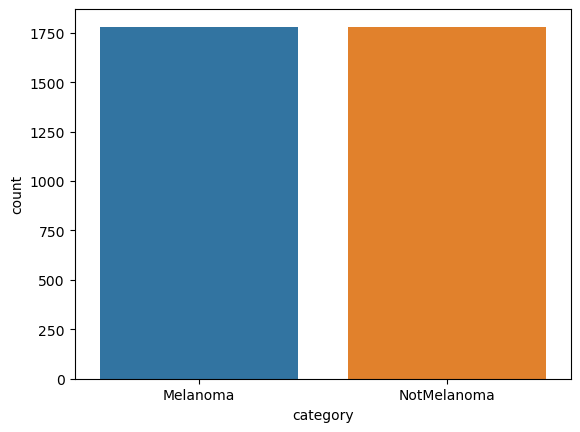

In [29]:
sns.countplot(data=test_df, x='category')
plt.show()

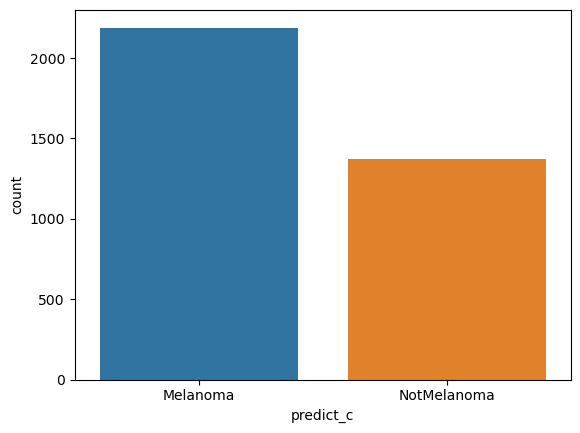

In [30]:
sns.countplot(data=test_df, x='predict_c')
plt.show()

In [31]:
val_pred=model.predict(val_dataset)

112/112 [==============================] - 13s 116ms/step


In [32]:
val_df["predict"]=np.argmax(val_pred,axis=1)

In [33]:
val_df["predict_c"]=val_df["predict"].map({0:"NotMelanoma",1:"Melanoma"})

In [34]:
val_df

,filename,category,predict,predict_c
0,Melanoma/AUGmented_0_1006.jpeg,Melanoma,1,Melanoma
1,Melanoma/AUGmented_0_1058.jpeg,Melanoma,0,NotMelanoma
2,Melanoma/AUGmented_0_110.jpeg,Melanoma,0,NotMelanoma
3,Melanoma/AUGmented_0_1108.jpeg,Melanoma,0,NotMelanoma
4,Melanoma/AUGmented_0_1140.jpeg,Melanoma,1,Melanoma
...,...,...,...,...
3557,NotMelanoma/ISIC_0034292.jpg,NotMelanoma,1,Melanoma
3558,NotMelanoma/ISIC_0034297.jpg,NotMelanoma,1,Melanoma
3559,NotMelanoma/ISIC_0034305.jpg,NotMelanoma,0,NotMelanoma
3560,NotMelanoma/ISIC_0034308.jpg,NotMelanoma,1,Melanoma


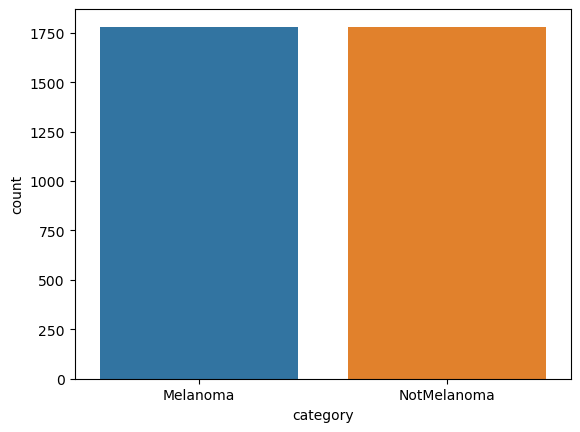

In [35]:
sns.countplot(data=val_df, x='category')
plt.show()

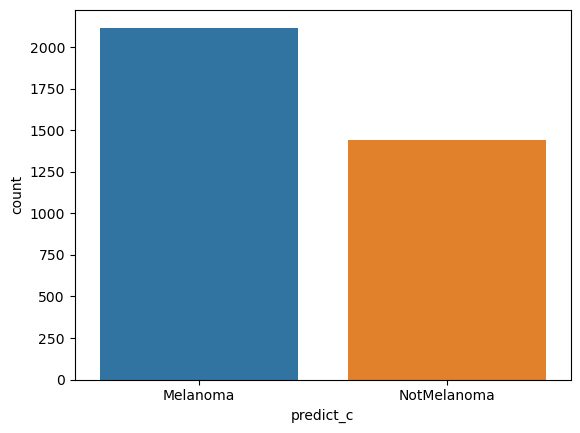

In [36]:
sns.countplot(data=val_df, x='predict_c')
plt.show()

In [37]:
val_df['predict_c'].value_counts()

Melanoma       2118
NotMelanoma    1444
Name: predict_c, dtype: int64

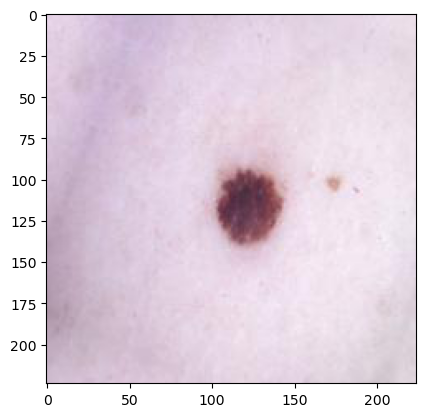

In [38]:
img = plt.imread('./DermMel/valid/Melanoma/AUGmented_0_1058.jpeg')
plt.imshow(img)
plt.show()

In [39]:
img = np.resize(a=img, new_shape=(Image_Width, Image_Height))
img = np.reshape(a=img, newshape=[Image_Height, Image_Width, Imag])

ValueError: cannot reshape array of size 62500 into shape (250,250,3)

In [40]:
read_model = load_model("./melanoma-classifier.h5", compile=False)

In [43]:
op = read_model.predict(img)

ValueError: in user code:

    File "C:\Users\Sam Nijin\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\Sam Nijin\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Sam Nijin\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\Sam Nijin\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 1983, in predict_step
        return self(x, training=False)
    File "C:\Users\Sam Nijin\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\Sam Nijin\AppData\Roaming\Python\Python39\site-packages\keras\engine\input_spec.py", line 250, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer "sequential" "                 f"(type Sequential).
    
    Input 0 of layer "conv2d" is incompatible with the layer: expected min_ndim=4, found ndim=2. Full shape received: (None, 250)
    
    Call arguments received by layer "sequential" "                 f"(type Sequential):
      • inputs=tf.Tensor(shape=(None, 250), dtype=uint8)
      • training=False
      • mask=None


In [ ]:
np.argmax(img)

In [ ]:
model.predict(np.argmax(img , axis=1))